<a href="https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/3_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Regresión lineal con PyTorch
Curso: Aprendizaje profundo

Alumno: Daniel Alonso

Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada. Especificaciones:
* Grafica los datos en 3D.
* Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio
nivel.
* Prueba distintos valores para los hiperparámetros.
* Realiza una predicción con tu modelo entrenado para la calificación que tendría un
alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo
obtuvo 3 de calificación.
* Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.
-----------------------

# 1 Preparación

## 1.1 Librerías

In [ ]:
!pip install torchinfo
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os
import time

# visualizacion
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

# tomar n elementos de una secuencia
from itertools import islice as take

# barras de progreso
from tqdm.auto import trange

# separar conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

## 1.2 Auxiliares

In [ ]:
# datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# 2 Datos

## 2.1 Descarga y visualización

In [ ]:
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘../data’: File exists
File ‘../data/califs.csv’ already there; not retrieving.


Carga del conjunto de datos de calificaciones. Los atributos son:
* `prev` es la calificación de un examen previo
* `horas` es el tiempo en horas de estudio del alumno
* `calif` es la calificación del examen

In [ ]:
df = pd.read_csv(filepath)
print(f'El dataset cuenta con {df.shape[0]} filas y {df.shape[1]} atributos \n')
df.head(5)

El dataset cuenta con 50 filas y 3 atributos 



,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Gráfica 3D de los datos

De la gráfica se observa que hay una correlación positiva tanto en las horas de estudio como en la califación de un examen previo con la califación del examen, i.e., en caso de haber tenido una calificación buena del examen previa y estudiar más tiempo es más probable obtener una buena calificación y viceversa.

In [ ]:
fig = px.scatter_3d(df, x='prev', y='horas', z='calif',color='calif', 
                    title='Calificaciones',opacity=0.7,
                    color_continuous_scale='rdylgn')
fig.show()

## 2.2 Crear conjuntos de prueba y entrenamiento

In [ ]:
def generate_ds(df,test_size=0.2):
  '''
  Funcion para generar los datasets de entrenamiento y prueba
  '''
  # separar en conjuntos de prueba y entrenamiento
  df_train, df_test = train_test_split(df, test_size=test_size, 
                                       random_state=42, shuffle=True)
  
  # generar vectores para despues pasarlos a tensores
  x_trn = np.array(df_train.iloc[:,:2], dtype="float32")
  y_trn = np.array(df_train.iloc[:,-1], dtype="float32")[..., np.newaxis]

  x_tst = np.array(df_test.iloc[:,:2], dtype="float32")
  y_tst = np.array(df_test.iloc[:,-1], dtype="float32")[..., np.newaxis]

  # pasar a tensores
  x_trn = torch.tensor(x_trn)
  y_trn = torch.tensor(y_trn)

  x_tst = torch.tensor(x_tst)
  y_tst = torch.tensor(y_tst)

  # convertir a dataset
  ds_trn = TensorDataset(x_trn, y_trn)
  ds_tst = TensorDataset(x_tst, y_tst)

  return ds_trn, ds_tst

# cargador de datos
def build_dl(ds_train,ds_test,batch_size=16, shuffle=True):
  # generar dataloaders (dl) de un dataset (ds)
  dl_train = DataLoader(ds_train,batch_size=batch_size,shuffle=shuffle)
  dl_test = DataLoader(ds_test,batch_size=batch_size,shuffle=shuffle)
  return dl_train, dl_test

A continuación se genera el cargador de datos.

In [ ]:
train_data, test_data = generate_ds(df,test_size=0.2)
print(f'El conjunto de entrenamiento cuenta con {len(train_data)} instancias')
print(f'El conjunto de prueba cuenta con {len(test_data)} instancias')

El conjunto de entrenamiento cuenta con 40 instancias
El conjunto de prueba cuenta con 10 instancias


Para ver el funcionamiento de la tubería de datos se imprime la forma de cada lote

In [ ]:
# crear un DataLoader
train_loader, test_loader = build_dl(train_data,test_data)

x, y = next(iter(train_loader))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x, y = next(iter(test_loader))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32
x shape=torch.Size([10, 2]) dtype=torch.float32
y shape=torch.Size([10, 1]) dtype=torch.float32


# 3 Modelo

## 3.1 Definición de la arquitectura con la interfaz de medio nivel

A continuación se define una función que regresa la arquitectura de una red completamente conectada, en dicha red se pueden variar el número de entradas `n_inputs`, el número de capas ocultas `n_layers`, el número de neuronas en las capas ocultas `n_neurons` y la función de activación entre ReLU, sigmoide y tanh. Se realizó empleando `ModuleDict` para tener la capacidad de realizar experimentos para variar la función de activación, el ancho y profundidad de la red.

In [ ]:
def LinRegMed(n_inputs=2, n_layers=1, n_neurons=5, activation_function = 'ReLU'):
  '''
  Crear el modelo con los siguientes inputs:
  n_inputs (int) - numero de entradas de la red
  n_layers (int) - numero de capas ocultas en la red
  n_neurons (int) - numero de neuronas en la(s) capa(s) oculta(s)
  activation_function - funcion de activacion: ReLU, Sigmoid, tanh
  '''
  class FCN(nn.Module):
    def __init__(self,n_inputs, n_layers, n_neurons, activation_function):
      super().__init__() # inicializacion de la clase padre

      # seleccion de la funcion de activacion
      if activation_function == 'ReLU': self.activation = F.relu
      if activation_function == 'Sigmoid': self.activation = torch.sigmoid
      if activation_function == 'tanh': self.activation = torch.tanh
    
      # definicion de un diccionario para guardar las capas
      self.layers = nn.ModuleDict()

      # capa de entrada
      self.layers['input'] = nn.Linear(n_inputs,n_neurons)

      # capas ocultas
      for i in range(n_layers):
        self.layers[f'hidden{i}'] = nn.Linear(n_neurons, n_neurons)

      # capa de salida
      self.layers['output'] = nn.Linear(n_neurons,1)

    def forward(self,x):
      # entrada
      x = self.activation(self.layers['input'](x))
      # capas ocultas
      for i in range(n_layers):
        x = self.activation(self.layers[f'hidden{i}'](x))
      
      # salida
      x = self.layers['output'](x)

      return x
  
  return FCN(n_inputs,n_layers, n_neurons, activation_function)

## 3.2 Instancia e información de la arquitectura base

La arquitectura base que se empleará para la ejecución de experimentos consta de 2 entradas (`prev` y `horas`), una capa de oculta con 5 unidades, y una capa de salida con una unidad, dado que es un problema de regresión. La función que se emplea es ReLU al ser una función no saturada.



In [ ]:
LinRegMed()

FCN(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=5, bias=True)
    (hidden0): Linear(in_features=5, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=1, bias=True)
  )
)

# 4 Ciclo de entrenamiento

A continuación se colocan las funciones para realizar el entrenamiento.

In [ ]:
def train_epoch(data_loader,model,opt):
  # loop sobre cada lote en el conjunto de entrenamiento
  for x, y_true in data_loader:
    # se realiza inferencia
    y_hat = model(x)
    # se calcula la perdida
    loss = F.mse_loss(y_hat, y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses = []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in data_loader:
      y_hat = model(x) # calculamos y_hat
      loss_b = F.mse_loss(y_hat, y_true) # calculo de la perdida
      losses.append(loss_b.item() * 100) # guardar historial de perdida para el lote
    
    # se obtiene el promedio
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          L2lambda=0,progress=True):
  # historiales
  loss_hist = []

  # optimizadores
  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  # ciclo de entrenamiento
  for epoch in range_progress:
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer)
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss = eval_epoch(train_dl, model)
    test_loss = eval_epoch(test_dl, model)
    # actualizar historial
    loss_hist.append([train_loss,test_loss])

    # impresion del progreso
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]')
      
  return loss_hist

def train_model(build_model, train_ds, test_ds, n_inputs= 2, n_layers=1, 
                  n_neurons=5, activation_function = 'ReLU', batch_size=16, 
                  lr=1e-3, epochs=10, opt='SGD',L2lambda=0,progress=True, 
                  verbose_summary=False,high_level=False):
  '''
  Funcion para realizar el entrenamiento de un modelo
  
  Inputs:
  build_model: funcion para instanciar un modelo
  train_ds: dataset de entrenamiento
  test_ds: dataset de prueba
  n_inputs (int) - numero de neuronas en la capa de entrada
  n_layers (int) - numero de capas ocultas en la red
  n_neurons (int) - numero de neuronas en la(s) capa(s) oculta(s)
  activation_function - funcion de activacion: ReLU, Sigmoid, tanh
  batch_size - tamaño de lote
  lr - tasa de aprendizaje
  epochs - numero de epocas a ejecutar
  opt - optimizados que se quiere utilizar: SGD, RMSprop, Adam
  L2lambda - regularizacion L2
  progress - booleano para indicar si se desea imprimir el progreso
  verbose_summary - booleano para indicar si se desea imprimir resumen de la red
  high_level - booleano para indicar si es interfaz de alto o medio nivel
  '''
  set_seed() # fijar semilla para reproducibilidad
  # generar DataLoader
  train_loader, test_loader = build_dl(train_ds,test_ds,batch_size)
  # instancia del modelo con sus parametros
  if high_level:
    model = build_model()
  else:
    model = build_model(n_inputs, n_layers, n_neurons, activation_function)
  # imprimir resumen en caso de ser requerido
  if verbose_summary:
    print(model)
  # entrenar el modelo
  loss_hist = train(model, train_loader, test_loader,epochs,lr,opt,
                    L2lambda,progress)

  return loss_hist, model

A continuación se realiza una ejecución de prueba para validar el correcto funcionamiento del entrenamiento.

In [ ]:
_,_ = train_model(LinRegMed, train_data, test_data, epochs=5, 
                  verbose_summary=True)

FCN(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=5, bias=True)
    (hidden0): Linear(in_features=5, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=1, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

E00 loss=[3115.87,3337.72]
E01 loss=[1838.81,1932.45]
E02 loss=[484.65,504.65]
E03 loss=[ 49.18, 66.59]
E04 loss=[ 15.96, 40.71]


# 5 Experimentos

Esta sección tiene como objetivo realizar distintos experimentos alrededor de los hiperparámetros con el fin de seleccionarlos de una mejor manera.

## 5.1 Funciones auxiliares para la visualización de resultados

En esta sección se especifican las funciones empleadas para la visualización de resultados de los experimentos.

In [ ]:
MARKER = 'o'
MARKER_SIZE = 4

def plot_loss_2param(loss_params,x_param,label_param,time_list=None,
                    x_label='',y_label='',x_lim=None,y_lim=None, n_avg=5):
  '''
  Funcion para graficar un experimento que varía 2 parametros
  '''
  # ajustar tamaño de la grafica dependiendo si se quiere mostrar la grafia de tiempos de ejecucion
  if time_list:
    fig,ax = plt.subplots(1,3,figsize=(20,6))
  else:
    fig,ax = plt.subplots(1,2,figsize=(15,6))

  # convertir a un numpy array la lista con los accuracies
  np_losses = np.array(loss_params,dtype=object)

  # generar 2 graficas, una para train y otra para test
  for i in range(2):
    # iterar por el parametro que se quiere como etiqueta
    for j in label_param:
      # filtrar por label_param
      filter_array = np_losses[np_losses[:,0] == j]
      # generar lista con las perdidas promedio de las ultimas epocas (n_avg)
      avg_loss_train = [np.mean(filter_array[:,2][x][-n_avg:]) for x in range(len(filter_array))]
      avg_loss_test = [np.mean(filter_array[:,3][x][-n_avg:]) for x in range(len(filter_array))]
      # grafica para train
      if i == 0:
        ax[i].plot(x_param,avg_loss_train,marker=MARKER,markersize=MARKER_SIZE,label=str(j))
        ax[i].set_title('Train')
      else:
        ax[i].plot(x_param,avg_loss_test,marker=MARKER,markersize=MARKER_SIZE,label=str(j))
        ax[i].set_title('Test')

    ax[i].legend()
    ax[i].grid()
    ax[i].set_ylabel(y_label)
    ax[i].set_xlabel(x_label)
    ax[i].set_xlim(x_lim)
    ax[i].set_ylim(y_lim)

  if time_list:
    np_time = np.array(time_list)
    # iterar por el parametro que se quiere como etiqueta
    for j in label_param:
      filter_array = np_time[np_time[:,0] == j]
      ax[2].plot(x_param,filter_array[:,2].astype('float64')/60,'o-',marker=MARKER,markersize=MARKER_SIZE,label=str(j))
    ax[2].legend()
    ax[2].grid()
    ax[2].set_ylabel('Time (min)')
    ax[2].set_xlabel(x_label)
    ax[2].set_title('Execution time')

  plt.show()

def plot_loss_2param_filter(losses,param0_name,param0_value,
                            param1_name,param1_value,
                            xlim=None,ylim=None,verbose=True):
  '''
  Graficar las perdidas del conjunto de entrenamiento y prueba filtrando a un valor
  especifico de los 2 parametros iterados
  '''
  # convertir a numpy arrays las listas con las perdidas
  losses_np = np.array(losses,dtype=object)
  # filtrar para obtener los valores de Adam
  losses_filter = losses_np[losses_np[:,0] == param0_value]
  # filtrar para un lr especifico
  losses_filter = losses_filter[losses_filter[:,1] == param1_value]
  # obtener las perdidas en la ultima epoca
  last_loss_train = losses_filter[-1,2][-1]
  last_loss_test = losses_filter[-1,-1][-1]

  # imprimir en pantalla la perdida en la ultima epoca
  if verbose:
    print(f'Pérdida del conjunto de entrenamiento: {last_loss_train:6.2f}')
    print(f'Pérdida del conjunto de prueba: {last_loss_test:6.2f}')

  # graficar ambos conjuntos
  plt.plot(losses_filter[0,2],label='Train',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(losses_filter[0,3],label='Test',marker=MARKER,markersize=MARKER_SIZE)
  plt.grid()
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.title(f'Loss with {param0_name} = {param0_value} and {param1_name}={param1_value}')
  plt.show()

## 5.2 Variación de los optimizadores y tasa de aprendizaje

A continuación se realiza un experimento al variar dos hiperparámetros, el optimizador `optim_types = ['SGD','RMSprop','Adam']` y la tasa de aprendizaje `learning_rates = [0.001,0.005,0.01,0.05,0.1]` del modelo base. Para cada experimento se guardan las pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es definir el mejor optimizador junto con la tasa de aprendizaje, y si es el caso, el número de épocas.

In [ ]:
# generar una lista con los lr y optimizadores a iterar
learning_rates = [0.001,0.005,0.01,0.05,0.1]
optim_types = ['SGD','RMSprop','Adam']

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_optim = []
time_per_optim = []

# iterar sobre los optimizadores
for i in trange(len(optim_types)):
  # iterar sobre los lr
  for j in trange(len(learning_rates)):
    # obtener optimizador y lr
    opt = optim_types[i]
    l_rate = learning_rates[j]

    # inicializar tiempo
    start = time.time()
    # entrenar modelo
    loss_hist_optim, _ = train_model(LinRegMed, train_data, test_data, 
                                     lr=l_rate, epochs=50,
                                     batch_size=16,
                                     opt=opt,progress=False)
    
    # calcular tiempo de ejecucion y actualizar lista
    execution_time = time.time() - start # en segundos
    time_per_optim.append([opt,l_rate,execution_time])

    # obtener las perdidas por funcion de activacion
    train_loss_optim, test_loss_optim = zip(*loss_hist_optim)
    losses_by_optim.append([opt,l_rate,train_loss_optim,test_loss_optim])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. La pérdida promedio alcanzada por optimizador en las últimas 5 épocas de entrenamiento para el conjunto de entrenamiento en función de la tasa de aprendizaje.
2. La pérdida promedio alcanzada por optimizador en las últimas 5 épocas de entrenamiento para el conjunto de prueba en función de la tasa de aprendizaje.
3. El tiempo de ejecución por optimizador en función de la tasa de aprendizaje.

De las gráficas se observa que:
* En el entrenamiento, se observa que SGD con `lr=0.001` tiene la menor pérdida, junto con Adam con `lr>0.001`, pero en el conjunto de prueba Adam con `lr=0.005` se mantiene que la menor pérdida.
* Se observa que en general, en el promedio de las últimas 5 épocas Adam tiene la menor pérdida en el conjunto de entrenamiento, específicamente con `lr=0.005`, con una pérdida de 35.64
* El tiempo de ejecución es muy pequeño, por lo tanto, no se considera como un criterio de selección del optimizador y la tasa de aprendizaje.
* En general, se observa, una diferencia constante entre las pérdidas del conjunto de entrenamiento y prueba, por lo que se puede generar la hipótesis de que no hay overfitting en casos especiales, pero para ello se realizan las gráficas de las pérdidas de ambos conjuntos en función de las épocas.


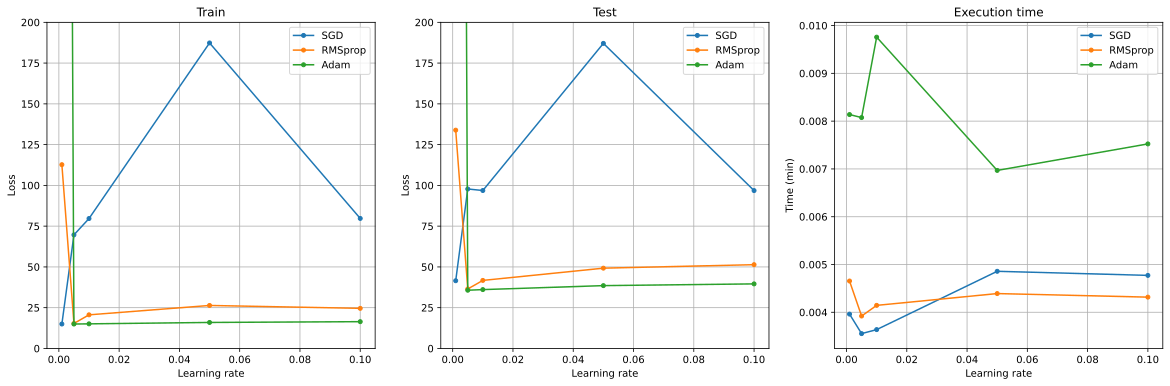

In [ ]:
plot_loss_2param(losses_by_optim,learning_rates,optim_types,time_list=time_per_optim,
                x_label='Learning rate',y_label='Loss',y_lim=[0,200])

A continuación se muestra las pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas, la primera gráfica es sin ajustar la escala de los ejes para ver el comportamiento general, y en la segunda se realiza una modificación en la escala para observar el detalle después de las 20 épocas.

Se observa que después de la época 45 se ven ambas pérdidas estables, además de que la separación existente entre ambas no divergen, se mantiene relativamente constante, por lo que no parece existir overfitting.

Pérdida del conjunto de entrenamiento:  14.84
Pérdida del conjunto de prueba:  35.64


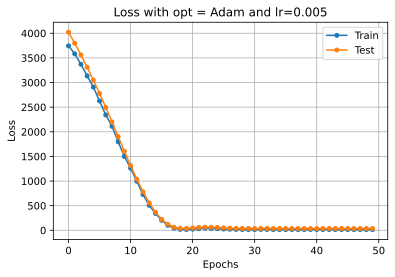

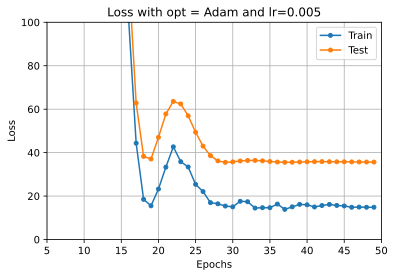

In [ ]:
plot_loss_2param_filter(losses_by_optim,'opt','Adam','lr',0.005)
plot_loss_2param_filter(losses_by_optim,'opt','Adam','lr',0.005,
                        ylim=[0,100],xlim=[5,50],verbose=False)

**Se concluye utilizar el optimizador Adam con una tasa de aprendizaje `lr=0.005` y un número de épocs `epochs=50` para el resto de los experimentos, dado que se tiene una pérdida menor tanto en el conjunto de entrenamiento como en el de prueba.**

## 5.3 Variación del tamaño de lote y el número de neuronas en la capa oculta

A continuación se realiza un experimento al variar dos hiperparámetros, el tamaño de lote `batch_sizes = [8,16,32,64]` y el número de neuronas en la capa oculta `numunits = [1...10]` del modelo base con el optimizador, tasa de aprendizaje y número de épocas obtenidas en el experimento anterior. Para cada experimento se guardan las pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es definir el mejor tamaño de lote junto con el número de neuronas en la capa oculta.

In [ ]:
# generar una lista con los tamaños de lote y neuronas en la capa oculta a iterar
batch_sizes = [8,16,32,64]
numunits  = np.arange(1,11,1) # numero de neuronas por capa oculta

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_exp = []
time_per_exp = []

# iterar sobre el tamaño de lote
for i in trange(len(batch_sizes)):
  # iterar sobre el numero de neuronas
  for j in trange(len(numunits)):
    # obtener optimizador y lr
    batch_size = batch_sizes[i]
    n_units = numunits[j]

    # inicializar tiempo
    start = time.time()
    # entrenar modelo
    loss_hist_exp, _ = train_model(LinRegMed, train_data, test_data, 
                                     lr=0.005, epochs=50,
                                     batch_size=batch_size,
                                     n_neurons=n_units,
                                     opt='Adam',progress=False)
    
    # calcular tiempo de ejecucion y actualizar lista
    execution_time = time.time() - start # en segundos
    time_per_exp.append([batch_size,n_units,execution_time])

    # obtener las perdidas por funcion de activacion
    train_loss_exp, test_loss_exp = zip(*loss_hist_exp)
    losses_by_exp.append([batch_size,n_units,train_loss_exp,test_loss_exp])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. La pérdida promedio alcanzada por tamaño de lote en las últimas 5 épocas de entrenamiento para el conjunto de entrenamiento en función del número de neuronas en la capa oculta.
2. La pérdida promedio alcanzada por tamaño de lote en las últimas 5 épocas de entrenamiento para el conjunto de prueba en función del número de neuronas en la capa oculta.
3. El tiempo de ejecución por tamaño de lote en función del número de neuronas en la capa oculta.

De las gráficas se observa que:
* Para el caso de tener un número de neuronas `numunits=1,2,4` se tienen pérdidas promedio mucho mayores que los demás casos.
* Para el tamaño de lote batch_size=64 también se tienen pérdidas promedio mayores que los demás casos.
* El tiempo de ejecución se impacta en mayor medida al variar el tamaño de lote, y aumenta el tiempo de ejecución al disminuir el tamaño de lote. Pero, los tiempos de ejecución son de magnitud pequeña, por lo que, el criterio de selección no se basará en el tiempo de ejecución sino que en la disminución de la pérdida.

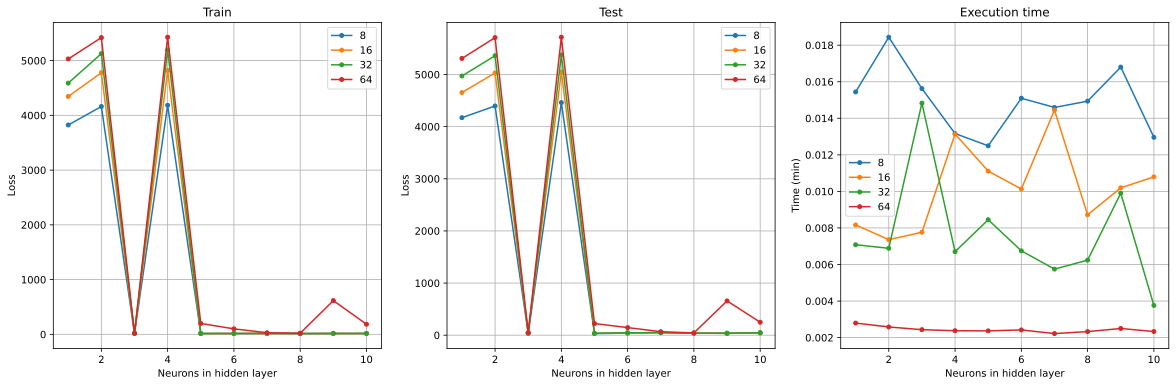

In [ ]:
plot_loss_2param(losses_by_exp,numunits,batch_sizes,time_list=time_per_exp,
                x_label='Neurons in hidden layer',y_label='Loss',y_lim=None)

Para realizar una selección más precisa, se realizan las mismas gráficas pero en un rango de interés para observar el comportamiento de las combinaciones de menor pérdida.

* En el conjunto de entrenamiento se observa que el de menor pérdida es el caso de un tamaño de lote de 32 con 8 neuronas en la capa oculta, pero en el conjunto de prueba, las pérdidas no son las menores.
* Los casos de un tamaño de lote de 8 y 16, con 5 neuronas en la capa oculta parecen ser los más consistentes.

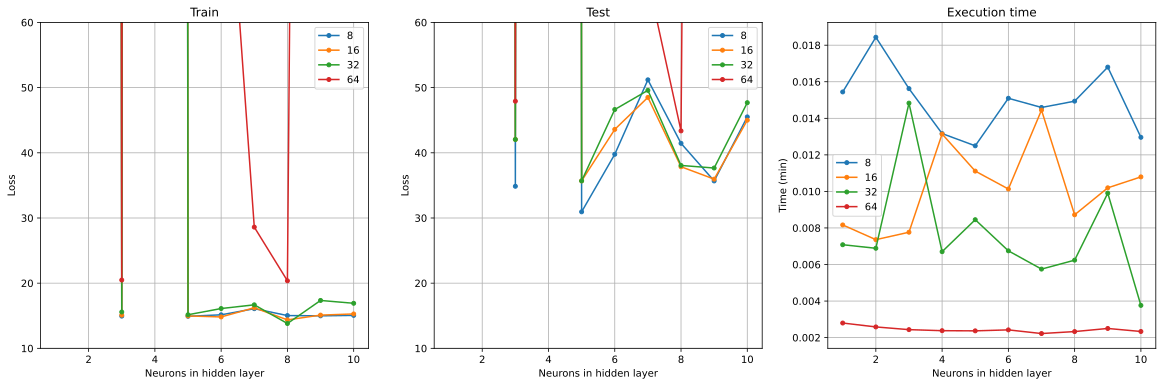

In [ ]:
plot_loss_2param(losses_by_exp,numunits,batch_sizes,time_list=time_per_exp,
                x_label='Neurons in hidden layer',y_label='Loss',y_lim=[10,60])

Para seleccionar entre ambas opciones, se grafican las pérdidas en función de las épocas para cada opción:

* La pérdida en el conjunto de entrenmiento entre amabas opciones es muy parecida, pero la pérdida en el conjunto de prueba de la primera opción es menor que la segunda opción (que es el caso base).
* El entrenamiento en ambas opciones se ve estable, mientras que al evaluar en el conjunto de prueba se observa más errático en la primera opción, pero oscila en promedio en 30.
* Dado que la diferencia de pérdidas en el conjunto de pruebas es diferente, se decide ir por la primera opción dado que disminuye dichas pérdidas.


Pérdida del conjunto de entrenamiento:  14.91
Pérdida del conjunto de prueba:  23.61


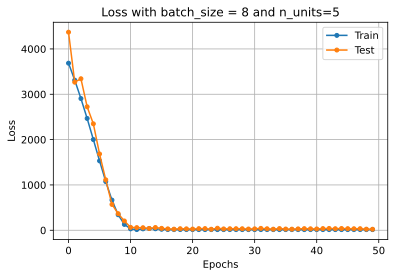

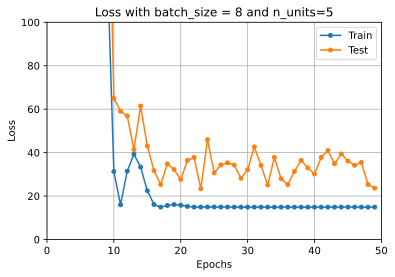

In [ ]:
plot_loss_2param_filter(losses_by_exp,'batch_size',8,'n_units',5)
plot_loss_2param_filter(losses_by_exp,'batch_size',8,'n_units',5,
                        ylim=[0,100],xlim=[0,50],verbose=False)

Pérdida del conjunto de entrenamiento:  14.84
Pérdida del conjunto de prueba:  35.64


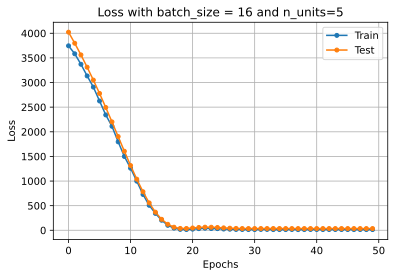

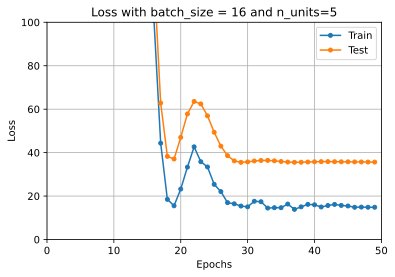

In [ ]:
plot_loss_2param_filter(losses_by_exp,'batch_size',16,'n_units',5)
plot_loss_2param_filter(losses_by_exp,'batch_size',16,'n_units',5,
                        ylim=[0,100],xlim=[0,50],verbose=False)

**Se concluye utilizar un tamaño de lote `batch_size=8` y un número de neuronas en la caca oculta `n_neurons=5` para el resto de los experimentos, dado que se tiene una pérdida menor en el conjunto de prueba.**

## 5.4 Variación de L2

A continuación se realiza un experimento la constante $\lambda$ para la regularización L2 `l2lambdas = [0,0.02,0.04,0.06,0.08,0.1]` del modelo base. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas.

In [ ]:
# generar una lista con los tamaños de lote y neuronas en la capa oculta a iterar
l2lambdas = np.linspace(0,0.1,6)

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_l2 = []
time_per_l2 = []

# iterar sobre el tamaño de lote
for i in trange(len(l2lambdas)):
  # obtener optimizador y lr
  l2lambda = l2lambdas[i]

  # inicializar tiempo
  start = time.time()
  # entrenar modelo
  loss_hist_l2, _ = train_model(LinRegMed, train_data, test_data, 
                                    lr=0.005, epochs=50,
                                    batch_size=8,
                                    n_neurons=5,
                                    opt='Adam',
                                    L2lambda=l2lambda,
                                    progress=False)
  
  # calcular tiempo de ejecucion y actualizar lista
  execution_time = time.time() - start # en segundos
  time_per_l2.append(execution_time)

  # obtener las perdidas por funcion de activacion
  train_loss_l2, test_loss_l2 = zip(*loss_hist_l2)
  losses_by_l2.append([train_loss_l2,test_loss_l2])

  0%|          | 0/6 [00:00<?, ?it/s]

A continuación se imprimen las pérdidas promedio en las últimas 5 épocas para ambos conjuntos en función de $\lambda$:

* Para $\lambda\geq0.04$ se observa una disminución en la pérdida en el conjunto de entrenamiento, pero un aumento de la misma en el conjunto de prueba.
* No se observa una mejora significativa al modificar el parámetro $\lambda$ para la regularización L2.

In [ ]:
for i in range(len(losses_by_l2)):
  avg_loss_train = np.mean(losses_by_l2[i][0][-5:])
  print(f'Pérdida promedio del conjunto de entrenamiento para L2lamda = {l2lambdas[i]} es de{avg_loss_train:6.2f}')

Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.0 es de 14.92
Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.02 es de 14.91
Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.04 es de 14.81
Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.06 es de 14.82
Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.08 es de 14.86
Pérdida promedio del conjunto de entrenamiento para L2lamda = 0.1 es de 14.87


In [ ]:
for i in range(len(losses_by_l2)):
  avg_loss_test = np.mean(losses_by_l2[i][1][-5:])
  print(f'Pérdida promedio del conjunto de prueba para L2lamda = {l2lambdas[i]} es de{avg_loss_test:6.2f}')

Pérdida promedio del conjunto de prueba para L2lamda = 0.0 es de 30.94
Pérdida promedio del conjunto de prueba para L2lamda = 0.02 es de 30.93
Pérdida promedio del conjunto de prueba para L2lamda = 0.04 es de 32.18
Pérdida promedio del conjunto de prueba para L2lamda = 0.06 es de 31.71
Pérdida promedio del conjunto de prueba para L2lamda = 0.08 es de 31.41
Pérdida promedio del conjunto de prueba para L2lamda = 0.1 es de 31.28


**Se concluye usar $\lambda=0$ dado que no se observa una diferencia significativa en las pérdidas, y así no se incrementa complejidad al modelo**

# 6 Arquitectura final

La conclusión de todos los experimentos realizados es utilizar una arquitectura:
1. Una capa de entrada con 2 neuronas 
2. Una capa oculta con 5 neuronas
3. Una capa de salida
4. Utilizar ReLU como función de activación
5. Utilizar Adam como optimizador
6. Utilizar una tasa de aprendizaje de 0.005
7. Utilizar un tamaño de lote de 8
8. Entrenar por 50 épocas

## 6.1 Entrenamiento

In [ ]:
loss_hist, model_f = train_model(LinRegMed, train_data, test_data, 
                                 lr=0.005, epochs=50,batch_size=8,
                                 n_neurons=5,L2lambda=0.0,opt='Adam',
                                 progress=True,verbose_summary=True)

FCN(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=5, bias=True)
    (hidden0): Linear(in_features=5, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=1, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

E00 loss=[3685.88,4369.76]
E01 loss=[3311.47,3266.54]
E02 loss=[2905.48,3342.47]
E03 loss=[2466.76,2724.15]
E04 loss=[2001.17,2348.41]
E05 loss=[1531.23,1683.51]
E06 loss=[1074.64,1113.88]
E07 loss=[666.12,570.34]
E08 loss=[342.39,366.96]
E09 loss=[129.39,205.50]
E10 loss=[ 31.29, 65.04]
E11 loss=[ 15.99, 59.03]
E12 loss=[ 31.45, 56.88]
E13 loss=[ 39.28, 41.38]
E14 loss=[ 33.33, 61.44]
E15 loss=[ 22.46, 43.08]
E16 loss=[ 16.10, 31.71]
E17 loss=[ 14.92, 25.34]
E18 loss=[ 15.67, 34.82]
E19 loss=[ 16.09, 32.22]
E20 loss=[ 15.77, 27.62]
E21 loss=[ 15.24, 36.43]
E22 loss=[ 14.94, 37.76]
E23 loss=[ 14.91, 23.37]
E24 loss=[ 14.97, 45.99]
E25 loss=[ 14.97, 30.68]
E26 loss=[ 14.94, 34.33]
E27 loss=[ 14.93, 35.32]
E28 loss=[ 14.91, 34.26]
E29 loss=[ 14.91, 28.20]
E30 loss=[ 14.91, 32.12]
E31 loss=[ 14.91, 42.64]
E32 loss=[ 14.91, 34.12]
E33 loss=[ 14.91, 25.08]
E34 loss=[ 14.90, 37.79]
E35 loss=[ 14.90, 27.98]
E36 loss=[ 14.91, 25.28]
E37 loss=[ 14.90, 31.33]
E38 loss=[ 14.91, 36.42]
E39 loss=[ 

## 6.2 Visualización de resultados

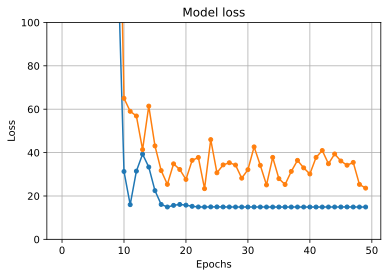

In [ ]:
train_loss, test_loss = zip(*loss_hist)

plt.plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
plt.plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
plt.ylim([0,100])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.grid()
plt.show()

In [ ]:
with torch.no_grad():
  losses_tst = []
  print('x,y_true,y_hat,loss:')
  for x,y_true in test_data:
    y_hat = model_f(x)
    loss = F.mse_loss(y_hat, y_true)
    losses_tst.append(loss.item())
    print(f'{x},{y_true}, {y_hat},{loss.item()}')

  print(f'Test loss: {np.mean(losses_tst)}')

x,y_true,y_hat,loss:
tensor([ 7.1000, 11.5000]),tensor([7.9000]), tensor([7.1137]),0.618257462978363
tensor([ 7.3000, 13.1000]),tensor([8.1000]), tensor([7.9026]),0.03896171227097511
tensor([ 5.5000, 12.5000]),tensor([6.7000]), tensor([7.3178]),0.3816470801830292
tensor([ 6.6000, 13.7000]),tensor([8.5000]), tensor([8.0686]),0.18609388172626495
tensor([ 7.0000, 11.5000]),tensor([6.4000]), tensor([7.0970]),0.4857432246208191
tensor([ 8.7000, 13.9000]),tensor([9.1000]), tensor([8.5149]),0.34238797426223755
tensor([ 7.5000, 12.0000]),tensor([7.6000]), tensor([7.4168]),0.03356848657131195
tensor([ 5.5000, 11.9000]),tensor([7.4000]), tensor([7.0345]),0.13358987867832184
tensor([ 6.0000, 12.8000]),tensor([7.]), tensor([7.5432]),0.29504501819610596
tensor([ 4.2000, 11.7000]),tensor([5.7000]), tensor([6.7223]),1.0450598001480103
Test loss: 0.3560354519635439


De los resultados obtenidos en el conjunto de prueba se observa que el modelo no generaliza bien para el caso de calificaciones previas abajo de 5 y con horas de estudio previas grandes.

## 6.3 Inferencia

Predicción de la calificación que tendrá un alumno si estudió durante 12 horas para el examen y obtuvo 3 de califación en un examen previo.

In [ ]:
# inferencia
x_inf = torch.tensor([3.,12.])

with torch.no_grad():
  y_hat = model_f(x_inf)

  print(f'Un alumno con {int(x_inf[0])} de califación previa y {int(x_inf[1])} horas de estudio, se predice que obtendrá{y_hat.item():6.2f} de calificación en el examen.')

Un alumno con 3 de califación previa y 12 horas de estudio, se predice que obtendrá  6.66 de calificación en el examen.


# 7 Arquitectura final con interfaz de alto nivel

In [ ]:
def build_high():
    model = nn.Sequential(
        nn.Linear(2, 5),
        nn.ReLU(),
        nn.Linear(5,5),
        nn.ReLU(),
        nn.Linear(5, 1),
    )
    return model

build_high()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)

## 7.1 Entrenamiento

In [ ]:
loss_hist_high, model_high = train_model(build_high, train_data, test_data, 
                                 lr=0.005, epochs=50,batch_size=8,
                                 L2lambda=0.0,opt='Adam',
                                 progress=True,high_level=True)

  0%|          | 0/50 [00:00<?, ?it/s]

E00 loss=[3685.88,4369.76]
E01 loss=[3311.47,3266.54]
E02 loss=[2905.48,3342.47]
E03 loss=[2466.76,2724.15]
E04 loss=[2001.17,2348.41]
E05 loss=[1531.23,1683.51]
E06 loss=[1074.64,1113.88]
E07 loss=[666.12,570.34]
E08 loss=[342.39,366.96]
E09 loss=[129.39,205.50]
E10 loss=[ 31.29, 65.04]
E11 loss=[ 15.99, 59.03]
E12 loss=[ 31.45, 56.88]
E13 loss=[ 39.28, 41.38]
E14 loss=[ 33.33, 61.44]
E15 loss=[ 22.46, 43.08]
E16 loss=[ 16.10, 31.71]
E17 loss=[ 14.92, 25.34]
E18 loss=[ 15.67, 34.82]
E19 loss=[ 16.09, 32.22]
E20 loss=[ 15.77, 27.62]
E21 loss=[ 15.24, 36.43]
E22 loss=[ 14.94, 37.76]
E23 loss=[ 14.91, 23.37]
E24 loss=[ 14.97, 45.99]
E25 loss=[ 14.97, 30.68]
E26 loss=[ 14.94, 34.33]
E27 loss=[ 14.93, 35.32]
E28 loss=[ 14.91, 34.26]
E29 loss=[ 14.91, 28.20]
E30 loss=[ 14.91, 32.12]
E31 loss=[ 14.91, 42.64]
E32 loss=[ 14.91, 34.12]
E33 loss=[ 14.91, 25.08]
E34 loss=[ 14.90, 37.79]
E35 loss=[ 14.90, 27.98]
E36 loss=[ 14.91, 25.28]
E37 loss=[ 14.90, 31.33]
E38 loss=[ 14.91, 36.42]
E39 loss=[ 

## 7.2 Visualización de resultados

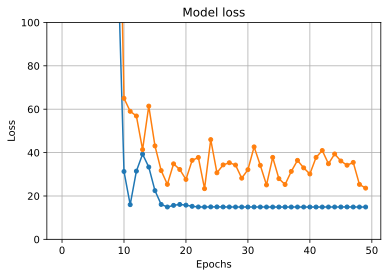

In [ ]:
train_loss_h, test_loss_h = zip(*loss_hist_high)

plt.plot(train_loss_h,label='Train',marker=MARKER,markersize=MARKER_SIZE)
plt.plot(test_loss_h,label='Test',marker=MARKER,markersize=MARKER_SIZE)
plt.ylim([0,100])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.grid()
plt.show()

## 7.3 Inferencia

In [ ]:
# inferencia
x_inf = torch.tensor([3.,12.])

with torch.no_grad():
  y_hat = model_high(x_inf)

  print(f'Un alumno con {int(x_inf[0])} de califación previa y {int(x_inf[1])} horas de estudio, se predice que obtendrá{y_hat.item():6.2f} de calificación en el examen.')

Un alumno con 3 de califación previa y 12 horas de estudio, se predice que obtendrá  6.66 de calificación en el examen.


Las arquitecturas desarrolladas tanto en la interfaz de alto como medio nivel son equivalentes y generan los mismos resultados.